# VAE for encoding Trajectories

Creates a (n/4) latent vectors of size 6 to represent a trajectory with n points. Notebook evaluates the model

In [20]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from quadrotor_diffusion.utils.trajectory import (
    derive_trajectory,
)

from quadrotor_diffusion.utils.dataset.dataset import QuadrotorRaceTrajectoryDataset, evaluate_dataset
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs

In [21]:
model: VAE_Wrapper = None
ema: VAE_Wrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", 118)
eval, _, normalizer, trainer_args = Trainer.load(chkpt)
data = QuadrotorRaceTrajectoryDataset('../data', ["linear", "u"], 360, normalizer)
print(chkpt)

../logs/training/118.VAE_Wrapper.Feb.17_02:32_PM/checkpoints/epoch_149_loss_0.0602


In [22]:
eval = eval.to('cuda')
sample = data[126]
ref_pos = normalizer.undo(sample)

def decoder(mu, padding):
    model_out = eval.decode(mu).squeeze(0).cpu().numpy()
    model_out = model_out[padding:-padding, :]
    reconstructed = normalizer.undo(model_out)
    return reconstructed


inp = torch.tensor(sample).float().unsqueeze(0).cuda()
start = time.time()
mu, logvar = eval.encode(inp, padding=0)
encode = time.time()
reconstructed = eval.decode(mu, padding=0).squeeze(0).cpu().numpy()
encode_time = encode - start
decode_time = time.time() - encode

print(f"Encoded in {encode_time:.1e}, decoded in {decode_time:.1e}")

Encoded in 5.8e-03, decoded in 5.1e-03


/tmp/ipykernel_176377/3493646871.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float().unsqueeze(0).cuda()


### Visualizing reconstructed result on a random sample

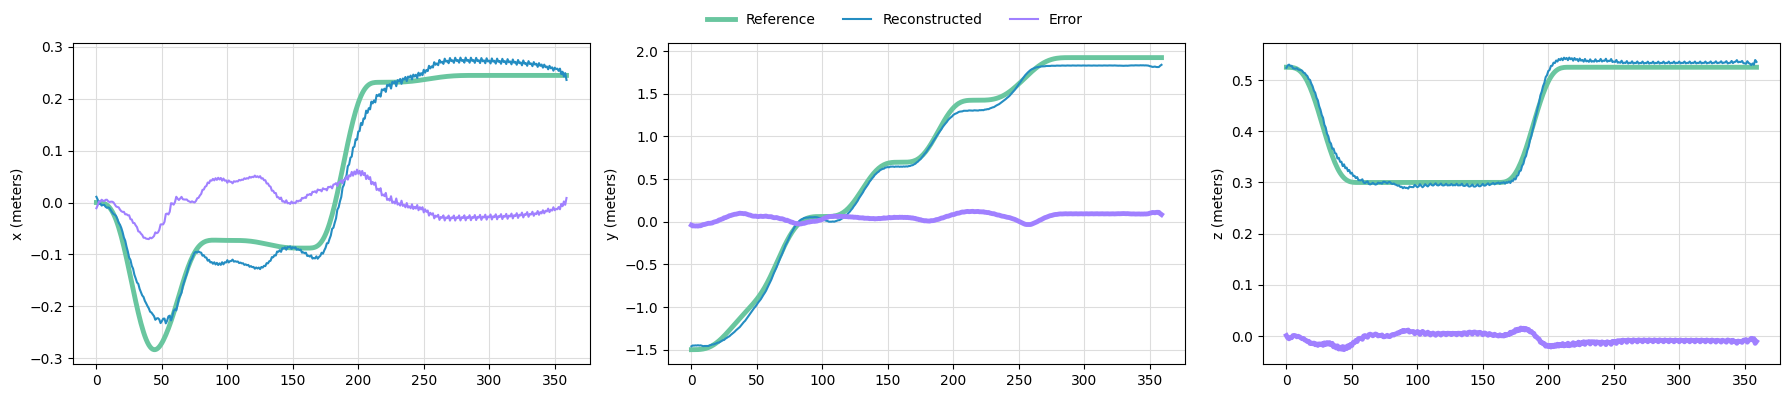

In [23]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(ref_pos[:, 0], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 0] - reconstructed[:, 0], label='Error', linewidth=1.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(ref_pos[:, 1], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 1] - reconstructed[:, 1], label='Error', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(ref_pos[:, 2], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 2] - reconstructed[:, 2], label='Error', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference', 'Reconstructed', 'Error'], loc='upper center', ncol=3, frameon=False)
plt.show()

### Interpolation between two samples
Adjust `beta0` and `beta1` for weighted interpolation

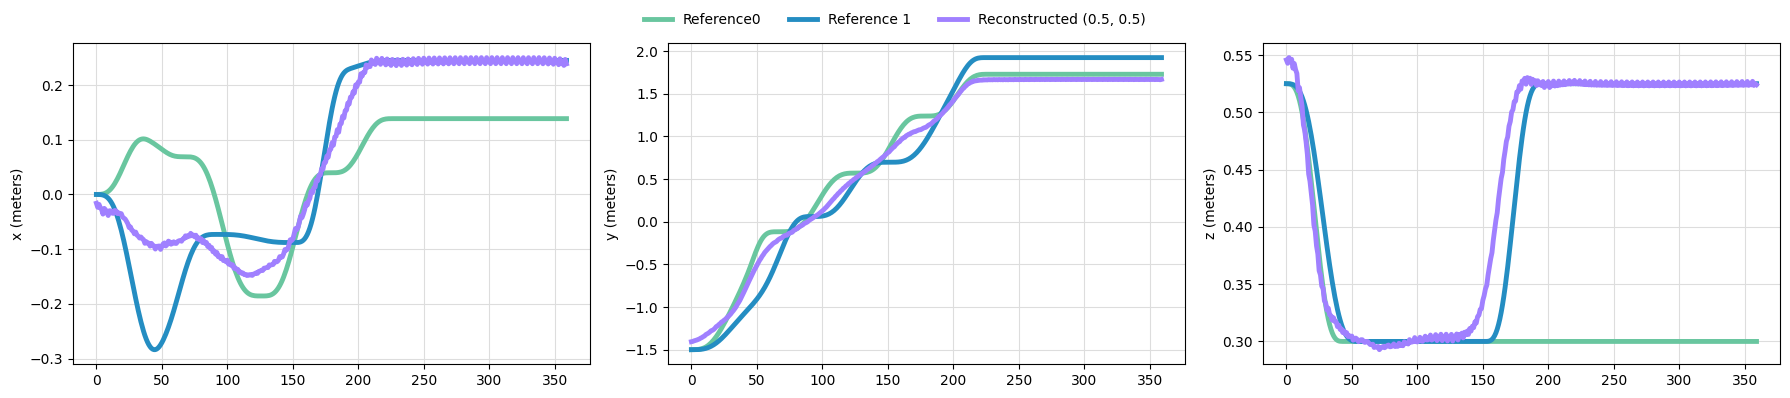

In [24]:
sample0 = data[16]
sample1 = data[117]

reference0 = normalizer.undo(sample0).numpy()
reference1 = normalizer.undo(sample1).numpy()

mu1, _ = eval.encode(sample0.unsqueeze(0).cuda(), padding=32)
mu2, _ = eval.encode(sample1.unsqueeze(0).cuda(), padding=32)

beta0 = 0.5
beta1 = 0.5
mu = beta0 * mu1 + beta1 * mu2
reconstructed = eval.decode(mu, padding=32).squeeze(0).cpu().numpy()

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(reference0[:, 0], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 0], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reference 1', linewidth=3.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(reference0[:, 1], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 1], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reference 1', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(reference0[:, 2], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 2], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reference 1', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference0', "Reference 1", f'Reconstructed ({beta0}, {beta1})'], loc='upper center', ncol=3, frameon=False)
plt.show()


### Testing adding noise to latent trajectory

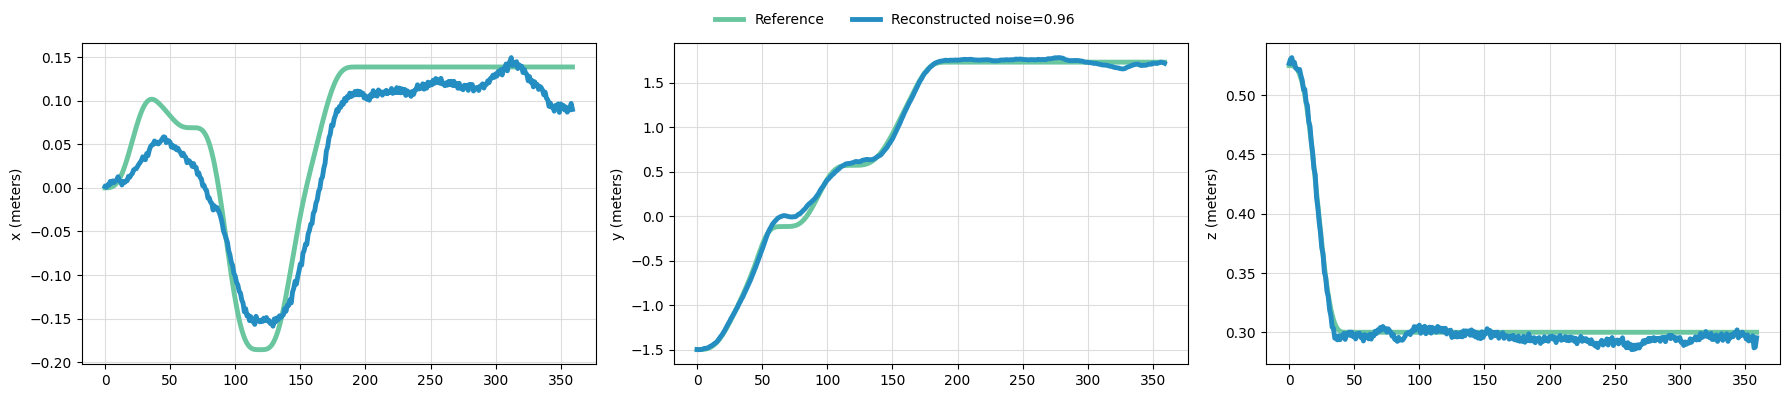

In [25]:
sample0 = data[0]

reference0 = normalizer.undo(sample0).numpy()

mu, logvar = eval.encode(sample0.unsqueeze(0).cuda(), padding=0)
noise = torch.randn_like(mu)
n_l = 1.0
std = n_l * torch.exp(0.5 * logvar)
mu_noise = mu + std * noise

reconstructed = eval.decode(mu_noise, 0).squeeze(0).cpu().numpy()

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(reference0[:, 0], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reference 1', linewidth=3.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(reference0[:, 1], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reference 1', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(reference0[:, 2], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reference 1', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference', f"Reconstructed noise={std.mean():.2f}"], loc='upper center', ncol=2, frameon=False)
plt.show()


### Visualizing Latent Space

In [26]:
# Cell 1
all_courses = []
all_indices = []
course_types = ["linear","u"]
batch_size = 1000
for mode in course_types:
    data = QuadrotorRaceTrajectoryDataset('../data',[mode],360,normalizer)
    course_mu = []
    course_ids = []
    for i in range(0,len(data),batch_size):
        batch_samples = []
        idxs = []
        for j in range(i,min(i+batch_size,len(data))):
            sample = data[j]
            inp = torch.tensor(sample).float()
            padding = 32
            top_row = inp[0].unsqueeze(0).repeat(padding,1)
            bottom_row = inp[-1].unsqueeze(0).repeat(padding,1)
            inp = torch.cat([top_row,inp,bottom_row],dim=0).unsqueeze(0)
            batch_samples.append(inp)
            idxs.append(j)
        batch = torch.cat(batch_samples,dim=0).cuda()
        mu,_ = eval.encode(batch)
        mu_flat = mu.reshape(mu.size(0),-1).cpu().numpy()
        course_mu.append(mu_flat)
        course_ids.append(np.array(idxs))
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    all_courses.append(np.concatenate(course_mu,axis=0))
    all_indices.append(np.concatenate(course_ids,axis=0))

/tmp/ipykernel_176377/3991176739.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float()


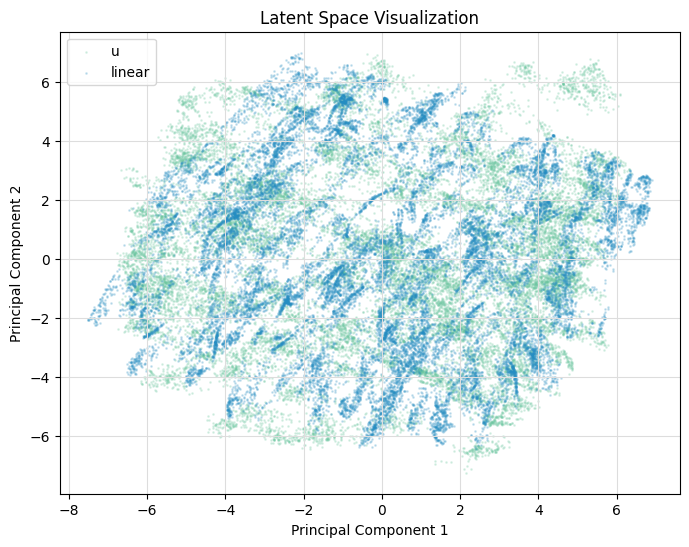

In [27]:
pca = PCA(n_components=2)
latent_spaces = [pca.fit_transform(mu_flat) for mu_flat in all_courses]
plt.figure(figsize=(8,6))
for latent_space,course_type in zip(latent_spaces[::-1],course_types[::-1]):
    # if course_type=='u':
    #     continue
    plt.scatter(latent_space[:,0],latent_space[:,1],alpha=0.2,s=1,label=course_type)
legend = plt.legend()
plt.title('Latent Space Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [28]:
# Cell 3
mode_query0 = "u"
coord0 = (-3, 0.5)
mode_query1 = "u"
coord1 = (0.5, -3)

def get_latent_references(mode_query0, coord0, mode_query1, coord1):
    data0 = QuadrotorRaceTrajectoryDataset('../data',[mode_query0],360,normalizer)
    ls0 = latent_spaces[course_types.index(mode_query0)]
    ids0 = all_indices[course_types.index(mode_query0)]
    dist0 = ((ls0 - coord0)**2).sum(axis=1)
    idx0 = np.argmin(dist0)
    reference0 = data0[ids0[idx0]]

    data1 = QuadrotorRaceTrajectoryDataset('../data',[mode_query1],360,normalizer)
    ls1 = latent_spaces[course_types.index(mode_query1)]
    ids1 = all_indices[course_types.index(mode_query1)]
    dist1 = ((ls1 - coord1)**2).sum(axis=1)
    idx1 = np.argmin(dist1)
    reference1 = data1[ids1[idx1]]
    return reference0, reference1
